# Prueba Técnica Arkon

Autor: Juan Carlos Hernández Rangel<br>
Desarrollo: 30-noviembre-2022

## Problema

En Los Ángeles existe un sistema compartido de bicicletas que brinda datos anónimos acerca
del uso del servicio. La tabla que se proporciona contiene el histórico de viajes que se han
realizado desde 2016 y contiene una columna que es de particular interés y que se buscará
analizar a más profundidad: Passholder_type. 

## Metodología

### Funciones

In [1]:
def f_rango_intercuartil(valores):
    Q1 = valores.quantile(0.25)
    Q3 = valores.quantile(0.75)
    IQR = Q3 - Q1
    limite_superior = Q3 + 1.5*IQR
    limite_inferior = Q1 - 1.5*IQR
    return (limite_inferior, limite_superior)

def f_z_score(valores):
    return np.abs(zscore(valores))

def f_limites_z_score(valores, umbral):
    upper_boundary = valores.mean() + umbral * valores.std()
    lower_boundary = valores.mean() - umbral * valores.std()
    return lower_boundary, upper_boundary

def f_capping(limite_inferior, limite_superior, valores):
    return np.where(
                    valores > limite_superior, 
                    limite_superior, 
                    np.where(
                            valores < limite_inferior,
                            limite_inferior,
                            valores))

def generar_estadisticas_basicas(serie):
    '''
    Función para obtener estadísticas básicas de la serie
    '''
    sesgo = skew(serie)
    kurto = kurtosis(serie)
    estadisticas_basicas = pd.DataFrame(serie.describe())
    estadisticas_basicas.loc["skew"] = sesgo
    estadisticas_basicas.loc["kurtosis"] = kurto
    return estadisticas_basicas

### Importar librerías

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine import transformation as vt
from scipy.stats import zscore
from scipy.stats import skew, kurtosis

### Importar conjunto de datos

In [3]:
path_entrenamiento = '../Data/train_set.csv'
dataFrame = pd.read_csv(path_entrenamiento, low_memory=False)

In [4]:
dataFrame.shape

(700000, 14)

In [5]:
dataFrame.head(3)

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
0,101750280,35,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,1.0,Round Trip,Walk-up,4127,4127
1,46560345,32,9/17/2017 17:51,9/17/2017 18:23,34.035679,-118.270813,34.047749,-118.243172,6683,0.0,One Way,Walk-up,3057,3062
2,120016336,6,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,30.0,One Way,Monthly Pass,3022,3062


### Feature Engineering

#### Variables a Eliminar

Datos los análisis previos (notebook 01), podemos eliminar algunas variables que no son necesarias.
1. Trip ID: Es solo un identificador.
2. Bike ID: Es solo un identificador.
3. Start time: El formato nos da complicaciones, es por ello que creamos más variables a partir de sus componentes como año, mes, dia, hora y minuto.
4. End time: El formato nos da complicaciones, es por ello que creamos más variables a partir de sus componentes como año, mes, dia, hora y minuto.
5. Start Station: Esta información ya viene implicita en el "Start Lat" y "Start Lon". Además, estaciones diferentes comparten valores. Por otro lado, usarla como variable nos traería problemas de dimensionalidad. En total son 364 estaciones.
6. End Station: Esta información ya viene implicita en el "End Lat" y "End Lon". Además, estaciones diferentes comparten valores. Por otro lado, usarla como variable nos traería problemas de dimensionalidad. En total son 364 estaciones.
7. Plan Duration: No se encuentra en el conjunto de prueba

Tampoco contemplaremos el día, mes y año del final del viaje, esto porque se dan en los mismos valores que el inicio del viaje. Contemplarlos significaría tener variables altamente correlacionadas

In [6]:
dataFrame["start_time"] = pd.to_datetime(dataFrame["start_time"], infer_datetime_format=True)
dataFrame["end_time"] = pd.to_datetime(dataFrame["end_time"], infer_datetime_format=True)

dataFrame["start_time_day"] = dataFrame["start_time"].dt.day
dataFrame["start_time_month"] = dataFrame["start_time"].dt.month
dataFrame["start_time_year"] = dataFrame["start_time"].dt.year
dataFrame["start_time_hour"] = dataFrame["start_time"].dt.hour
dataFrame["start_time_minute"] = dataFrame["start_time"].dt.minute

dataFrame["end_time_hour"] = dataFrame["end_time"].dt.hour
dataFrame["end_time_minute"] = dataFrame["end_time"].dt.minute

In [7]:
variables_no_necesarias = [
    "trip_id",
    "bike_id",
    "start_time",
    "end_time",
    "start_station",
    "end_station",
    "plan_duration"
]

dataFrame_Clean = dataFrame.drop(variables_no_necesarias, axis=1)
dataFrame_Clean.shape

(700000, 14)

In [8]:
dataFrame_Clean.head(2)

,duration,start_lat,start_lon,end_lat,end_lon,trip_route_category,passholder_type,start_time_day,start_time_month,start_time_year,start_time_hour,start_time_minute,end_time_hour,end_time_minute
0,35,33.748920,-118.275192,33.748920,-118.275192,Round Trip,Walk-up,7,8,2018,11,20,11,55
1,32,34.035679,-118.270813,34.047749,-118.243172,One Way,Walk-up,17,9,2017,17,51,18,23


#### Duration

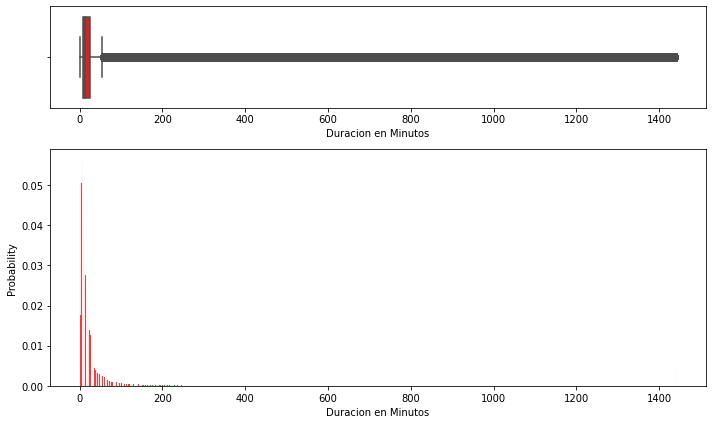

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6), tight_layout=True, gridspec_kw={'height_ratios':[0.6, 1.4]})
sns.boxplot(x=dataFrame_Clean["duration"], color='red', ax=axes[0])
sns.histplot(x=dataFrame_Clean["duration"], stat="probability", color='red', ax=axes[1])

axes[0].set_xlabel("Duracion en Minutos")
axes[1].set_xlabel("Duracion en Minutos");

In [10]:
tf_YJ = vt.YeoJohnsonTransformer(variables=["duration"])
dataFrame_Clean = tf_YJ.fit_transform(dataFrame_Clean)

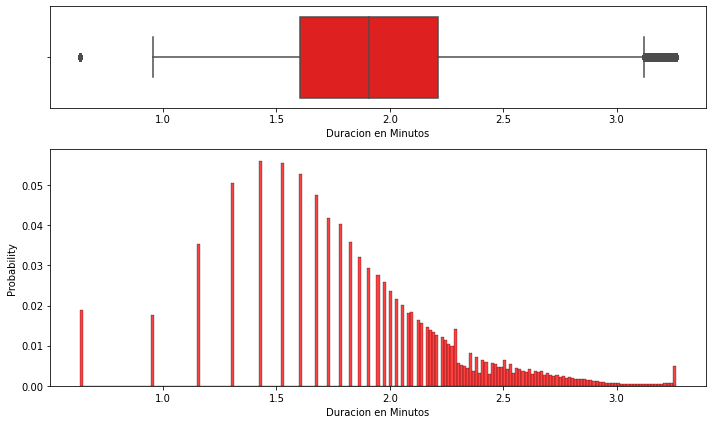

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6), tight_layout=True, gridspec_kw={'height_ratios':[0.6, 1.4]})
flatten_axes = axes.flatten()
sns.boxplot(x=dataFrame_Clean["duration"], color='red', ax=flatten_axes[0])
sns.histplot(x=dataFrame_Clean["duration"], stat="probability", color='red', ax=flatten_axes[1])

flatten_axes[0].set_xlabel("Duracion en Minutos")
flatten_axes[1].set_xlabel("Duracion en Minutos");

#### Start_lat | Start_lon | End_lat | End_lon

Eliminar nulos podría resultar problemático y debatible. Pero después de eliminar estos registros mantenemos el __96%__ de los registros totales. Un 4% de pérdida no resultaría contundente para el total de información que tenemos.

In [12]:
dataFrame_Clean = dataFrame_Clean.dropna()

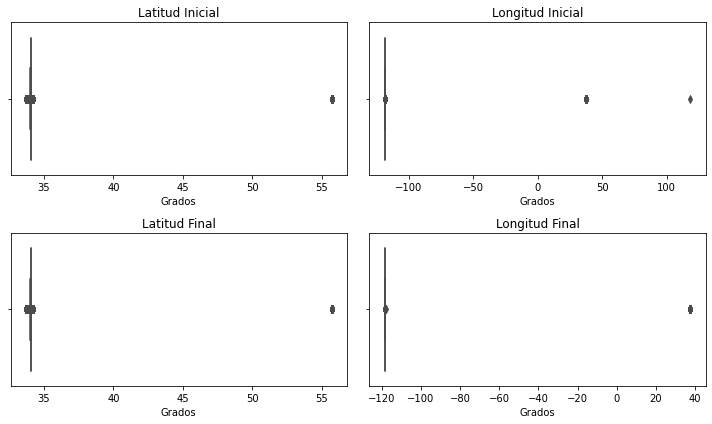

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6), tight_layout=True)
flatten_axes = axes.flatten()
sns.boxplot(x=dataFrame_Clean["start_lat"], color='red', ax=flatten_axes[0])
sns.boxplot(x=dataFrame_Clean["start_lon"], color='red', ax=flatten_axes[1])
sns.boxplot(x=dataFrame_Clean["end_lat"], color='red', ax=flatten_axes[2])
sns.boxplot(x=dataFrame_Clean["end_lon"], color='red', ax=flatten_axes[3])

flatten_axes[0].set_xlabel("Grados")
flatten_axes[1].set_xlabel("Grados")
flatten_axes[2].set_xlabel("Grados")
flatten_axes[3].set_xlabel("Grados")

flatten_axes[0].set_title("Latitud Inicial", size=12)
flatten_axes[1].set_title("Longitud Inicial", size=12)
flatten_axes[2].set_title("Latitud Final", size=12)
flatten_axes[3].set_title("Longitud Final", size=12);

In [14]:
s_lat_l, s_lat_u = f_rango_intercuartil(dataFrame_Clean["start_lat"])
s_lon_l, s_lon_u = f_rango_intercuartil(dataFrame_Clean["start_lon"])
e_lat_l, e_lat_u = f_rango_intercuartil(dataFrame_Clean["end_lat"])
e_lon_l, e_lon_u = f_rango_intercuartil(dataFrame_Clean["end_lon"])

In [15]:
data_capp_s_lat = f_capping(s_lat_l, s_lat_u, dataFrame_Clean["start_lat"])
data_capp_s_lon = f_capping(s_lon_l, s_lon_u, dataFrame_Clean["start_lon"])
data_capp_e_lat = f_capping(e_lat_l, e_lat_u, dataFrame_Clean["end_lat"])
data_capp_e_lon = f_capping(e_lon_l, e_lon_u, dataFrame_Clean["end_lon"])

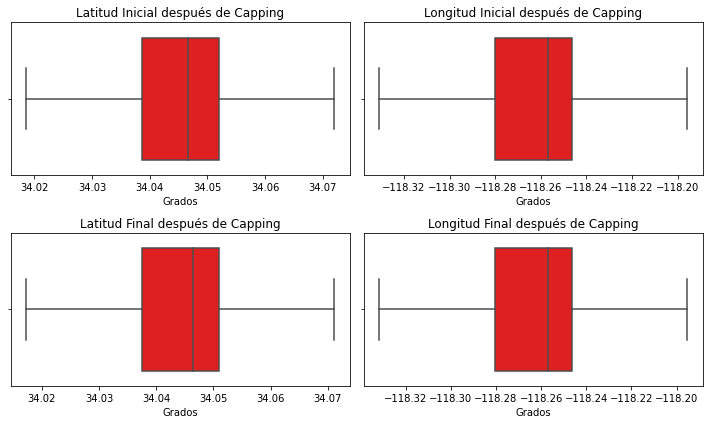

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6), tight_layout=True)
flatten_axes = axes.flatten()
sns.boxplot(x=data_capp_s_lat, color='red', ax=flatten_axes[0])
sns.boxplot(x=data_capp_s_lon, color='red', ax=flatten_axes[1])
sns.boxplot(x=data_capp_e_lat, color='red', ax=flatten_axes[2])
sns.boxplot(x=data_capp_e_lon, color='red', ax=flatten_axes[3])

flatten_axes[0].set_xlabel("Grados")
flatten_axes[1].set_xlabel("Grados")
flatten_axes[2].set_xlabel("Grados")
flatten_axes[3].set_xlabel("Grados")

flatten_axes[0].set_title("Latitud Inicial después de Capping", size=12)
flatten_axes[1].set_title("Longitud Inicial después de Capping", size=12)
flatten_axes[2].set_title("Latitud Final después de Capping", size=12)
flatten_axes[3].set_title("Longitud Final después de Capping", size=12);

In [17]:
dataFrame_Clean["start_lat"] = data_capp_s_lat
dataFrame_Clean["start_lon"] = data_capp_s_lon
dataFrame_Clean["end_lat"] = data_capp_e_lat
dataFrame_Clean["end_lon"] = data_capp_e_lon

#### passholder_type

In [18]:
total_datos_pass = pd.DataFrame(dataFrame_Clean["passholder_type"].value_counts())
total_porce_pass = pd.DataFrame(dataFrame_Clean["passholder_type"].value_counts(normalize=True)*100)
total_data_pass = pd.concat([total_datos_pass, total_porce_pass], axis=1)
total_data_pass

,passholder_type,passholder_type
Monthly Pass,387596,57.354758
Walk-up,203867,30.167346
One Day Pass,39888,5.902452
Annual Pass,32973,4.879200
Flex Pass,11420,1.689882
Testing,43,0.006363


Existe la clase __"Testing"__, la cual, dudo que este entre el conjunto de clases con las que normalmente se trabaja. Contemplarla nos traería algunos problemas, dado que hay valores que son específicos de esa clase, como en __plan duration__ que se tiene el valor de "999", además, es una clase con muy pocos registros. Después de eliminar valores nulos, la clase __"Testing"__ no representa ni el 1%.

In [19]:
dataFrame_Clean = dataFrame_Clean[dataFrame_Clean["passholder_type"] != "Testing"]

In [20]:
mapeo_passholder_type = {
    'Walk-up': 0,
    'Monthly Pass': 1,
    'One Day Pass': 2,
    'Annual Pass': 3,
    'Flex Pass': 4
}
dataFrame_Clean["passholder_type"] = dataFrame_Clean["passholder_type"].map(mapeo_passholder_type)

#### Plan Duration

#### Trip Route Category

In [21]:
total_datos_route = pd.DataFrame(dataFrame_Clean["trip_route_category"].value_counts())
total_porce_route = pd.DataFrame(dataFrame_Clean["trip_route_category"].value_counts(normalize=True)*100)
total_data_route = pd.concat([total_datos_route, total_porce_route], axis=1)
total_data_route

,trip_route_category,trip_route_category
One Way,560167,82.896334
Round Trip,115577,17.103666


In [22]:
mapeo_trip_route_category = {
    "Round Trip": 0,
    "One Way": 1
}
dataFrame_Clean["trip_route_category"] = dataFrame_Clean["trip_route_category"].map(mapeo_trip_route_category)

### Exportar Datos

In [23]:
dataFrame_Clean.to_csv("../Data/Train_Data_Clean.csv", index=False)